In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

December 2018

Reporter: Cissi

I januari 2019 kommer vi göra en 2-3:a på betygsskillnader mellan pojkar och flickor i åk 9. I den här filen hittar man alla beräkningar av data. Källa för datafilerna i Skolverket.

**NOTERA** 
Samtliga år i grundfilerna är efter vilket år eleverna började nian (läsårets början). Dessa räknas nedan om till vilket år slutbetyget sattes.

Resultatet publicerades i nr 2, 2019 och [finns här att läsa på webben](https://www.dagenssamhalle.se/nyhet/betygsgapet-vaxer-i-var-tredje-kommun-25707).

# Kommunerna

Först några funktioner som hjälper oss att formattera om Skolverkets hemska, hemska datafiler till något som är lite mer bearbetligt:

In [3]:
def col_formatting(df):
    """Mindre textformattering på kolumnerna"""
    df.columns = df.columns.str.lower()\
                            .str.replace("(\.)(?=\d)","_")\
                            .str.replace('\(%\) ','')\
                            .str.replace("\.",'')\
                            .str.replace(",","")\
                            .str.replace("\s\(16\)","")\
                            .str.replace(" ",'_')\
                            .str.replace("_\(\d+\)","")
    return df

In [4]:
def col_dict(file):
    """Återger en dict som visar vilka kön som kolumnnamnen \
i varje fil visar data för. Nyckeln i dicten är kolumnsindex."""
    cols = len(col_formatting(pd.read_csv(f'data/grund/{file}',header=4,sep=';',error_bad_lines=False)).columns)
    cols = list(range(0,cols))
    col_vars = pd.read_csv(f'data/grund/{file}',header=3,sep=';',error_bad_lines=False).iloc[0].index\
                .str.replace("\.\d",'').str.lower().str.strip()\
                .str.replace(",","").str.replace(" ","_")\
                .tolist()
    return dict(zip(cols,col_vars))

In [5]:
def col_fixer(df,cols):
    """Denna funktion tar kolumndictionaryn och ger varje \
kolumnnamn rätt suffix, t ex '_pojkar' till vad nu kolumnen \
heter. Detta används senare för att melta fram en enhetlig \
dataframe med korrekta datan."""
    
    df = df.loc[:,[x for x in df.columns if "name" not in x]]
    
    columns = df.columns.tolist()

    for i in range(len(columns)):
        if i in [0,1]:
            continue
        m = re.search(r'\d+$', columns[i])
        if m:
            columns[i] = columns[i][:-2]
        columns[i] = columns[i] + "_" + cols[i]
    
    df.columns = columns
    return df
    
    

In [6]:
def df_reformatter(df,year):
    """Denna funktion tar bort slaskraderna i botten på \
alla csv-filer (Skolverket envisas med att lägga info under \
tabellerna). Den meltar också ihop dataframen till en mer \
logisk datastruktur samt lägger till en kolumn för kön och \
för år.
"""
    
    # Korrekt årtal (höstterminen)
    year = int('20' + year)-1
    
    # Ta bort de nedersta slaskraderna
    df = df.loc[(~df['typ_av_huvudman'].isnull())&(df['typ_av_huvudman'].str.len()<9)]
    
    df['år'] = year
    
    # Melta ihop skiten
    df = df.melt(id_vars=['kommun',
                          'typ_av_huvudman',
                          'år'],
                 var_name='mått',
                 value_name='värde')
    
    # Skapa kolumn med info om kön
    df.loc[df['mått'].str.contains('pojk'),'kön'] = 'pojkar'
    df.loc[df['mått'].str.contains('tjej'),'kön'] = 'tjejer'
    df.loc[df['mått'].str.contains('flick'),'kön'] = 'tjejer'
    df.loc[df['mått'].str.contains('samtliga'),'kön'] = 'samtliga'
    
    return df[['kommun',
               'typ_av_huvudman',
               'år',
               'kön',
               'mått',
               'värde']]
    

Nu en loop över alla grundfiler:

In [7]:
df = pd.DataFrame()
for file in os.listdir('data/grund/'):
    year = (file[-6:-4])
    cols = col_dict(file)
    
    tmp = col_formatting(pd.read_csv(f'data/grund/{file}',header=4,sep=';'))
    tmp = col_fixer(tmp,cols)
    
    df = pd.concat([df,df_reformatter(tmp,year)])

För år 2015 så kom det så pass många nyanlända att man skapade en helt egen statistikkategori som var genomsnittsbetyg exklusive de med okänd bakgrund (dvs nyanlända). Dessa tar vi bort:

In [10]:
df = df.loc[~df.mått.str.contains('exklusive')]

In [11]:
for x in ['_inklusive_okänd_bakgrund','_flickor','_pojkar','_samtliga_elever']:
    df.mått = df.mått.str.replace(x,"")

Vissa kommuner har punkter istället för siffror. Två punkter innebär att udnerlaget är för litet för att man vill visa genomsnittssiffror (utlämnande för de eleverna), en punkt är att uppgift saknas. Båda dessa ersätts med nan-värden då det i vår beräkning de facto blir som ifall det saknas värde. Också:Ö det finns somliga kommuner som har värden som markeras med "~100". Detta är då i samband med ifall det är nästan 100 procent av eleverna som fått godkänt, men att det även där är för litet antal för att vara exakt. Dessa "~" tas bort, och sådana siffror tas bara som det står.

In [12]:
df.värde = df.värde.str.replace("\.","").str.replace("~","").str.replace(",",".").str.replace("\s","")
df.värde = pd.to_numeric(df.värde)

Vi vill endast kolla genomsnittisvärdena:

In [13]:
results = df.loc[df['mått']=='genomsnittligt_meritvärde']

Nu bryta ut så vi får pojkar och flickor i varsin kolumn:

In [16]:
results = results.loc[results['kön']=='tjejer'].rename(columns={'värde':'värde_flickor'}).reset_index(drop=True)\
    .merge(results.loc[results['kön']=='pojkar'].rename(columns={'värde':'värde_pojkar'})[['kommun','typ_av_huvudman','år','värde_pojkar']],
          on=['kommun','typ_av_huvudman','år'],how='left')

In [18]:
results['skillnad'] = results['värde_flickor'] - results['värde_pojkar']

In [21]:
results = results.loc[(results['typ_av_huvudman']=='Samtliga')&(results['år'].isin(list(range(2008,2018)))),['kommun','år','värde_pojkar','skillnad']]

In [28]:
results['skillnad_procent'] = ((results['skillnad']/results['värde_pojkar'])*100).round(1)

Nu ska vi pivotera data efter år så vi enklare kan beräkna med hur många procentenheters skillnad det har förändrats sedan betygsskillnaderna var som högst:

In [30]:
skillnad = results[['kommun','år','skillnad_procent']].pivot(index='kommun',columns='år',values='skillnad_procent')

In [31]:
skillnad.head()

år,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
kommun,,,,,,,,,,
Ale,16.8,8.2,6.9,21.7,21.4,13.4,8.4,30.3,30.6,10.3
Alingsås,15.3,13.3,12.0,6.9,15.7,11.1,17.1,14.9,13.6,15.5
Alvesta,19.0,24.1,5.7,7.1,11.3,16.0,26.1,14.5,23.7,11.5
Aneby,20.3,14.3,20.0,3.8,1.8,7.8,7.2,10.4,12.4,11.1
Arboga,8.5,8.2,2.6,-1.1,5.9,-2.1,14.2,8.8,7.7,10.5


Cissi bad mig i ett senare skede att ändra på årtalen. Varje läsår skrivs ut med hösttermin och vårtermin, och eftersom betygen kommer på våren så ville Cissi att vi därför använder det senare årtalet. Så istället för "2017/18" så blir det "2017":

In [32]:
skillnad.columns = [int(x)+1 for x in skillnad.columns if not x =='ämne']

In [35]:
skillnad['skillnader_2016_2018'] = skillnad[2018]-skillnad[2016]

Fyra kommuner saknar värde då de något av åren saknar siffror att beräkna på:

In [37]:
skillnad.loc[skillnad['skillnader_2016_2018'].isnull()]

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,skillnader_2016_2018
kommun,,,,,,,,,,,
Bjurholm,11.5,13.3,15.3,6.4,4.3,22.9,1.3,NaN,19.9,0.9,NaN
Dorotea,6.0,25.8,-1.3,24.7,NaN,3.8,NaN,NaN,15.9,23.8,NaN
Skinnskatteberg,18.9,33.0,29.4,NaN,NaN,15.4,33.9,11.0,27.9,NaN,NaN
Sorsele,4.3,2.0,8.1,NaN,16.9,74.8,-0.9,22.6,16.8,NaN,NaN


In [152]:
skillnad.to_excel('resultat/skillnad_2016.xlsx')

Sådär, nu har vi beräknat fram hur många procents skillnad det är mellan gapet i killars och tjejers betyg 2017 jämfört 2015. Nu sorterar vi fram senaste läsåret och lägger till denna kolumn till datat som ska skickas till Cissi:

In [38]:
results = results.loc[results['år']==2018,['kommun','värde_pojkar','skillnad','skillnad_procent']].reset_index(drop=True)

In [154]:
results.merge(skillnad[['skillnader_2016_2018']].reset_index(),on='kommun',how='left').sort_values('skillnader_2016_2018',ascending=False)\
    .rename(columns={
    'värde_pojkar':'Genomsnittspoäng pojkar (2017/18)',
    'skillnad':'Skillnad i genomsnittspoäng (2017/18)',
    'skillnad_procent':'Skillnad i procent (2017/18)',
    'skillnader_2016_2018':'Procentenheters skillnad, jämfört 2015/16'
    
}).reset_index(drop=True).to_excel('betygsskillnader_pojkar_flickor_2018.xlsx',index=False)

# Riket

Nu till beräkningar av rikssiffrorna:

In [39]:
df = pd.read_excel('data/riket.xlsx')

In [40]:
df.år = df.år.apply(lambda x: x[:4])

In [41]:
df = df.loc[df.år.astype('int') > 2007]

In [42]:
df.head()

,år,kön,genomsnittligt_meritvärde_16,kommun,fristående,sv_bakgrund,utl_bakgrund
15,2009,totalt,208.80,206.30,228.20,212.70,188.8
16,2010,totalt,210.60,207.70,229.50,214.70,191.8
17,2011,totalt,211.40,208.20,230.00,216.10,191.6
18,2012,totalt,213.10,209.70,231.40,218.10,193.7
19,2013,totalt,214.75,211.04,233.05,220.33,194.4


In [43]:
# sifferavrundning
df.iloc[:,2:] = df.iloc[:,2:].round(1)

Slår nu ihop allt i en rak dataframe

In [44]:
df = df.melt(id_vars=['år','kön'],var_name='mått',value_name='värde')

In [46]:
df.head()

,år,kön,mått,värde
0,2009,totalt,genomsnittligt_meritvärde_16,208.8
1,2010,totalt,genomsnittligt_meritvärde_16,210.6
2,2011,totalt,genomsnittligt_meritvärde_16,211.4
3,2012,totalt,genomsnittligt_meritvärde_16,213.1
4,2013,totalt,genomsnittligt_meritvärde_16,214.8


Bort med totalsiffrorna:

In [47]:
df = df.loc[df['kön']!='totalt']

Skapandet av två kolumner, en för pojkar och en för flickor:

In [48]:
df = df.pivot_table(index=['år','mått'],columns='kön',values='värde').reset_index()

In [49]:
df.head()

kön,år,mått,flickor,pojkar
0,2008,fristående,237.4,218.6
1,2008,genomsnittligt_meritvärde_16,220.6,198.9
2,2008,kommun,218.6,196.8
3,2008,sv_bakgrund,224.5,202.3
4,2008,utl_bakgrund,198.5,180.9


Beräkning av betygsskillnaderna nedan. Den slutgiltiga siffran visar då alltså hur många procent högre betyg som flickorna har, jämfört pojkarna:

In [50]:
df['skillnad_%'] = (((df['flickor']-df['pojkar'])/df['pojkar'])*100).round(1)

In [51]:
df = df.melt(id_vars=['år','mått'],var_name='vars',value_name='värde')

In [53]:
# Justera så att åren räknas efter det året betygen kom, inte när eleverna började nian
df.år = df.år.astype('int') + 1

In [57]:
df.loc[(df['mått']=='genomsnittligt_meritvärde_16')&(df['vars']=='skillnad_%')&\
       (df['år'].isin(list(range(2008,2019))))]\
        [['år','värde']].to_excel('resultat/riksskillnader.xlsx',index=False)

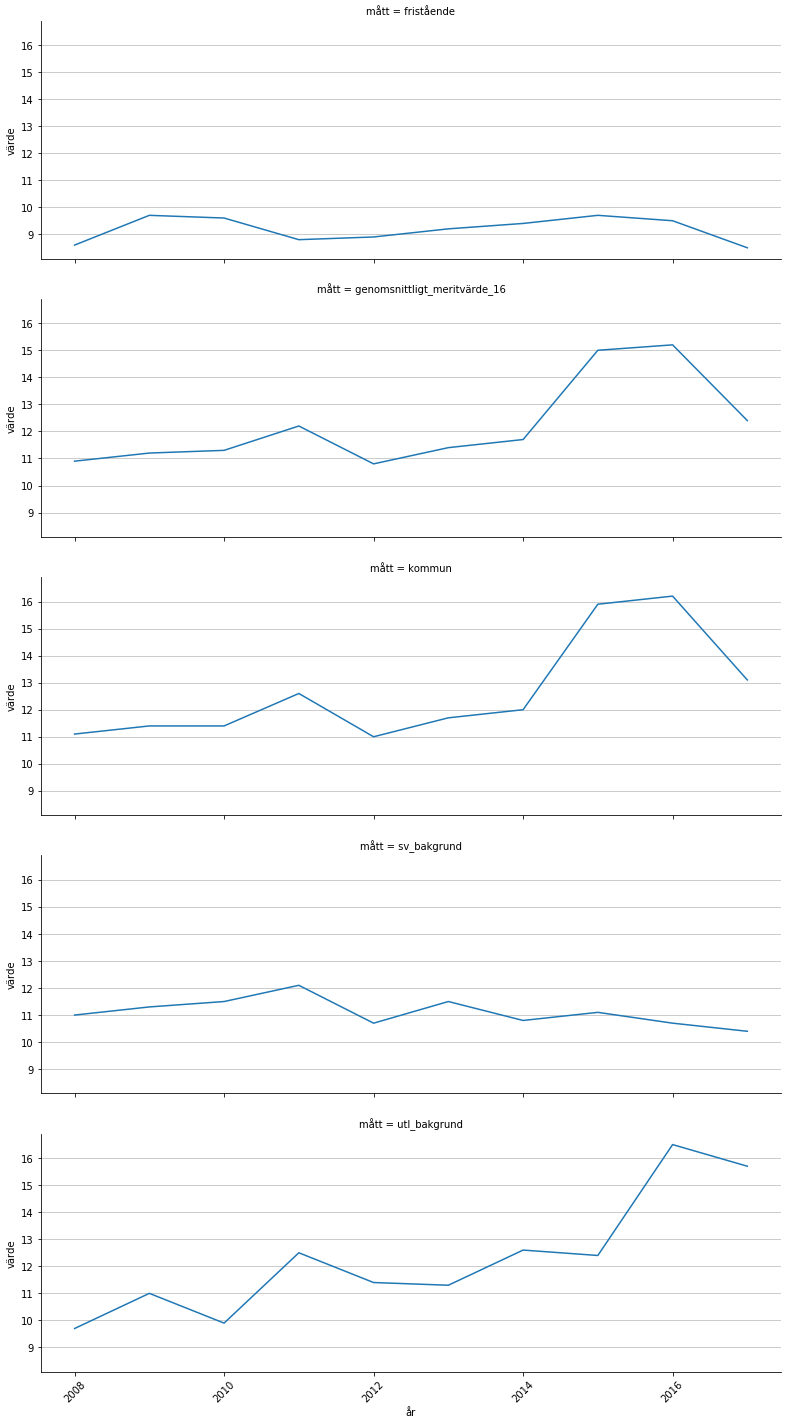

In [29]:
g = sns.FacetGrid(df.loc[df.vars=='skillnad_%'],col='mått',col_wrap=1)
g.map(plt.plot,'år','värde')


g.set_xticklabels(step=2,rotation=45)
g.fig.set_size_inches(15,20)

for a in g.axes:
    a.grid(True, axis='y', alpha=0.5, color='grey')

# Ämnen

Cissi har också önskat en överblick över betygen i alla ämnen för killar/tjejer. Så jag hämtade dessa från Skolverket

In [4]:
import os

In [5]:
cols = ['ämne', 'år', 'antal', 'poäng', 'andel_AE','kön']

Följande är används sedan som indexsiffror för de kolumner i grunddata som tillhör respektive grupp elever i datasettet:

In [7]:
flickor = [3,7,8]
pojkar = [4,9,10]
totalt = [2,5,6]

In [17]:
df = pd.DataFrame()
for file in os.listdir('data/ämnen/'):
    #print(file)
    if ".DS_" in file:
        continue
    tmp = pd.read_excel(f'data/ämnen/{file}',header=1)
    p = tmp.iloc[:,[0,1]+pojkar]
    p['kön'] = 'pojkar'
    f = tmp.iloc[:,[0,1]+flickor]
    f['kön'] = 'flickor'
    t = tmp.iloc[:,[0,1]+totalt]
    t['kön'] = 'totalt'
    
    for temp in [p,f,t]:
        temp.columns = cols
    tmp = pd.DataFrame()
    for temp in [p,f,t]:
        tmp = pd.concat([tmp,temp])
    
    tmp = tmp.melt(id_vars=['år','ämne','kön'],var_name='variabel',value_name='värde')
    df = pd.concat([df,tmp])

In [18]:
df.variabel.unique()

array(['antal', 'poäng', 'andel_AE'], dtype=object)

In [19]:
df = df.loc[(df['variabel']=='poäng')&(df['kön'].isin(['pojkar','flickor']))]

In [20]:
df.head()

,år,ämne,kön,variabel,värde
63,2012,Bild,pojkar,poäng,12.8
64,2012,Engelska,pojkar,poäng,14.0
65,2012,Hem och konsumentkunskap,pojkar,poäng,13.0
66,2012,idrott,pojkar,poäng,14.5
67,2012,Matematik,pojkar,poäng,12.5


In [22]:
df = df.pivot_table(index=['år','ämne'],columns='kön',values='värde').reset_index()

Andelsberäkning av betygsskillnaden härnäst. Siffran på skillnad visar hur många procent högre tjejer betyg tjejer har i förhållande till pojkar:

In [23]:
df['skillnad_%'] = (((df['flickor']-df['pojkar'])/df['pojkar'])*100).round(1)

In [24]:
df.head()

kön,år,ämne,flickor,pojkar,skillnad_%
0,2012,Bild,15.5,12.8,21.1
1,2012,Biologi,13.6,12.1,12.4
2,2012,Engelska,14.6,14.0,4.3
3,2012,Fysik,13.0,12.3,5.7
4,2012,Geografi,13.8,12.5,10.4


Så med andra ord, år 2012 hade flickor 21,1 % högre betyg än pojkar i ämnet bild.

In [25]:
resultat = df[['år','ämne','skillnad_%']].pivot(index='ämne',columns='år',values='skillnad_%')

In [102]:
# Justera så att åren räknas efter det året betygen kom, inte när eleverna började nian
resultat.columns = [int(x)+1 for x in resultat.columns if not x =='ämne']

In [81]:
resultat.reset_index().to_excel('ämnen.xlsx',index=False)